### Cookbook: abba-baba introgression stats

The *ipyrad.analysis* Python module includes functions to calculate abba-baba admixture statistics, as well as several variants of these measures, and to perform signifance tests. The code in this notebook is all Python, which you can copy/paste into an IPython terminal to execute, or, preferably, run in a Jupyter notebook like this one. See the other analysis cookbooks for [instructions](http://ipyrad.readthedocs.io/analysis.html) on using Jupyter notebooks.

In [45]:
## start by loading several Python librarires
import ipyrad as ip
from ipyrad.assemble.write_outfiles import reftrick, GETCONS
import ipyrad.analysis.baba as baba
import scipy.stats as st
import numpy as np
import pandas as pd
import numba
import itertools
import toyplot 
import toyplot.svg

In [46]:
import ipyparallel as ipp
ipyclient = ipp.Client()
lbview = ipyclient.load_balanced_view()
print ip.cluster_info()

  host compute node: [4 cores] on oud


### Load finished sim assembly

In [3]:
data = ip.load_json("cli/cli.json")

  loading Assembly: cli
  from saved path: ~/Documents/ipyrad/tests/cli/cli.json


### input arguments to test

In [4]:
## a dictionary with [required] key names 
## optional: additional 'p4' key for 5-taxon tests.
test = {
    'p4': ["3L_0", "3J_0", "3K_0"], 
    'p3': ["2E_0", "2F_0"],
    'p2': ["1D_0"],
    'p1': ["1A_0", "1B_0", "1C_0"],
}

## optional: dict for min samples per taxon (default=1 per tax)
## used to filter loci for inclusion in data set
mindict = {
    'p4': 1,
    'p3': 1,
    'p2': 1, 
    'p1': 1,
}

## loci input file
handle = data.outfiles.loci

In [8]:
## run a single test
stats, boots = baba.baba(handle, test, mindict, 1000)
stats

array([ 0.09677419,  0.12538285,  0.25664758,  0.37707035])

In [9]:
## run a batch of tests
tests = [test, test, test, test, test, test, test, test, test, test]
resarr, bootsarr = baba.batch(handle, tests, mindict, 1000, ipyclient)

  [####################] 100%  calculating D-stats  | 0:00:12 |  


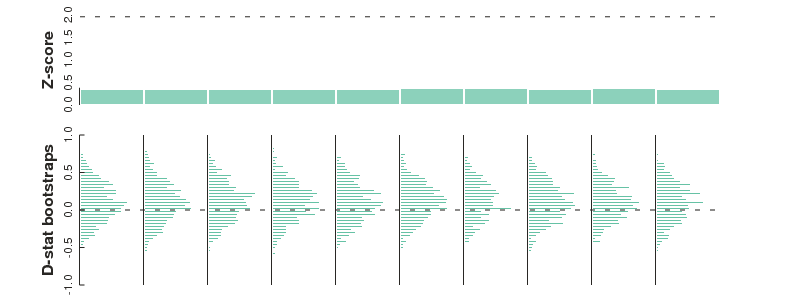

In [12]:
baba.bootplot(resarr, bootsarr, width=800, height=300)

In [111]:
import toyplot
import toyplot.generate
import igraph
import numpy as np
import ete3 as ete


def cladogram(newick, ignore_edge_lengths=True, invert=False):
    
    ## get tree
    tre = ete.Tree(newick=newick)
    tre.ladderize()
    tlen = tre.get_farthest_leaf(topology_only=ignore_edge_lengths)[1]
    
    ## map numeric values to nodes from root to tips in order
    idx = 0
    for node in tre.traverse("levelorder"):
        node.name = idx
        idx += 1
    
    ## fill edges and coords arrays
    edges = np.zeros((idx-1, 2), dtype=int)#"S")
    coord = np.zeros((idx, 2), dtype=float)
    
    ## map from tips to root
    tip_num = len(tre.get_leaves()) - 1
    for idx, node in enumerate(tre.traverse("postorder")):
        if node.is_leaf():
            edges[idx-1, :] = int(node.up.name), int(node.name)
            node.x = tip_num 
            node.y = 0
            tip_num -= 1
            coord[node.name] = [node.x, node.y]
        else:
            if not node.is_root():
                edges[idx-1, :] = int(node.up.name), int(node.name)
            node.x = (node.children[0].x + node.children[1].x) / 2.
            node.y = node.get_farthest_leaf(topology_only=ignore_edge_lengths)[1]
            coord[node.name] = [node.x, node.y] 
    
    ## flip tree?
    if invert:
        coord[:, 1] = np.abs(coord[:, 1] - tlen)

    return edges, coord

In [129]:
import toyplot
import toyplot.generate
import igraph
import numpy as np
import ete3 as ete


def phylogram(newick, ignore_edge_lengths=True, invert=False):
    
    ## get tree
    tre = ete.Tree(newick=newick)
    tre.ladderize()
    tlen = tre.get_farthest_leaf(topology_only=ignore_edge_lengths)[1]
    
    ## map numeric values to nodes from root to tips in order
    idx = 0
    for node in tre.traverse("levelorder"):
        node.name = idx
        idx += 1
    
    ## fill edges and coords arrays, way more in phylogram
    edges = np.zeros((idx*2-1, 2), dtype=int)
    ## nvertices is 2X internal + external
    nverts = sum([1 if i.is_leaf() else 2 for i in tre.traverse()])
    coords = np.zeros((nverts, 2), dtype=float)
    
    ## map from tips to root
    tip_num = len(tre.get_leaves()) - 1
    for idx, node in enumerate(tre.traverse("postorder")):
        if node.is_leaf():
            ## point your edge straight up to a new node number
            edges[idx-1, :] = int(idx), int(node.name)
            idx += 1
            
            ## tip coords are standard            
            node.x = tip_num 
            node.y = node.dist #0
            tip_num -= 1
            coords[node.name] = [node.x, node.y]
        else:
            ## treat the root
            if not node.is_root():
                edges[idx-1, :] = int(node.up.name), int(node.name)
            else:
                ## point edge straight up

            ## treat any internal edge
            ## find new node to the left
            edges[newnumber, :] = idx, int(node.name)
            idx += 1
            ## sides already have children pointing to them, so we just
            ## need to get edges from sides
            
            ## where is the left node
            coords[node.name] = [node.x - halfspace, node.y]
            coords[node.name] = [node.x + halfspace, node.y]
            
            ## find new node to the right         
            node.x = (node.children[0].x + node.children[1].x) / 2.
            node.y = node.get_farthest_leaf(topology_only=ignore_edge_lengths)[1]
            coord[node.name] = [node.x, node.y] 
    
    ## flip tree?
    if invert:
        coord[:, 1] = np.abs(coord[:, 1] - tlen)

    return edges, coords

IndentationError: expected an indented block (<ipython-input-129-d70af8338fcc>, line 49)

In [128]:
tre = ete.Tree(newick)

phylogram(newick)


(array([[1, 4],
        [0, 1],
        [3, 5],
        [4, 7],
        [5, 8],
        [2, 6],
        [0, 2],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 3]]), array([[ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 4.,  1.],
        [ 3.,  1.],
        [ 2.,  2.],
        [ 0.,  0.],
        [ 1.,  1.],
        [ 0.,  1.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.]]))

In [110]:
#newick="(((a,b),A), ((c,d), (e,f)));"
newick="(((a:1,b:1):1.5,c:2):1, (d:1,e:1):2);"
edges, coord = cladogram(newick, ignore_edge_lengths=False, invert=True)
edges, coord

(array([[1, 4],
        [0, 1],
        [2, 5],
        [6, 7],
        [6, 8],
        [2, 6],
        [0, 2],
        [1, 3]]), array([[ 2.375,  0.   ],
        [ 3.5  ,  2.5  ],
        [ 1.25 ,  1.   ],
        [ 4.   ,  3.5  ],
        [ 3.   ,  3.5  ],
        [ 2.   ,  3.5  ],
        [ 0.5  ,  2.5  ],
        [ 1.   ,  3.5  ],
        [ 0.   ,  3.5  ]]))

In [130]:
## my cladogram layout
newick = "/home/deren/Dropbox/Canarium_GBS/ipyrad/analysis_raxml/RAxML_bestTree.Can2_tree"
edges, coord = cladogram(newick, ignore_edge_lengths=True, invert=True)

## my phylogram layout
edges, coord = phylogram(newick)

axes = toyplot.Canvas(width=500, height=600)
gg = axes.cartesian()
gg.graph(edges, 
               vcoordinates=coord, 
               ewidth=3, 
               ecolor=toyplot.color.near_black, 
               vlshow=False,
               vsize=0,
               along='y')

ValueError: Expected 83 rows, received 124.

-0.5 0.0 0.5 -0.5 0.0 0.5

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

(410.0, 446.75, 50.0, 500.0)
(459.0, 495.75, 50.0, 500.0)
(508.0, 544.75, 50.0, 500.0)
(557.0, 593.75, 50.0, 500.0)
(606.0, 642.75, 50.0, 500.0)
(655.0, 691.75, 50.0, 500.0)
(704.0, 740.75, 50.0, 500.0)
(753.0, 789.75, 50.0, 500.0)
(802.0, 838.75, 50.0, 500.0)
(851.0, 887.75, 50.0, 500.0)


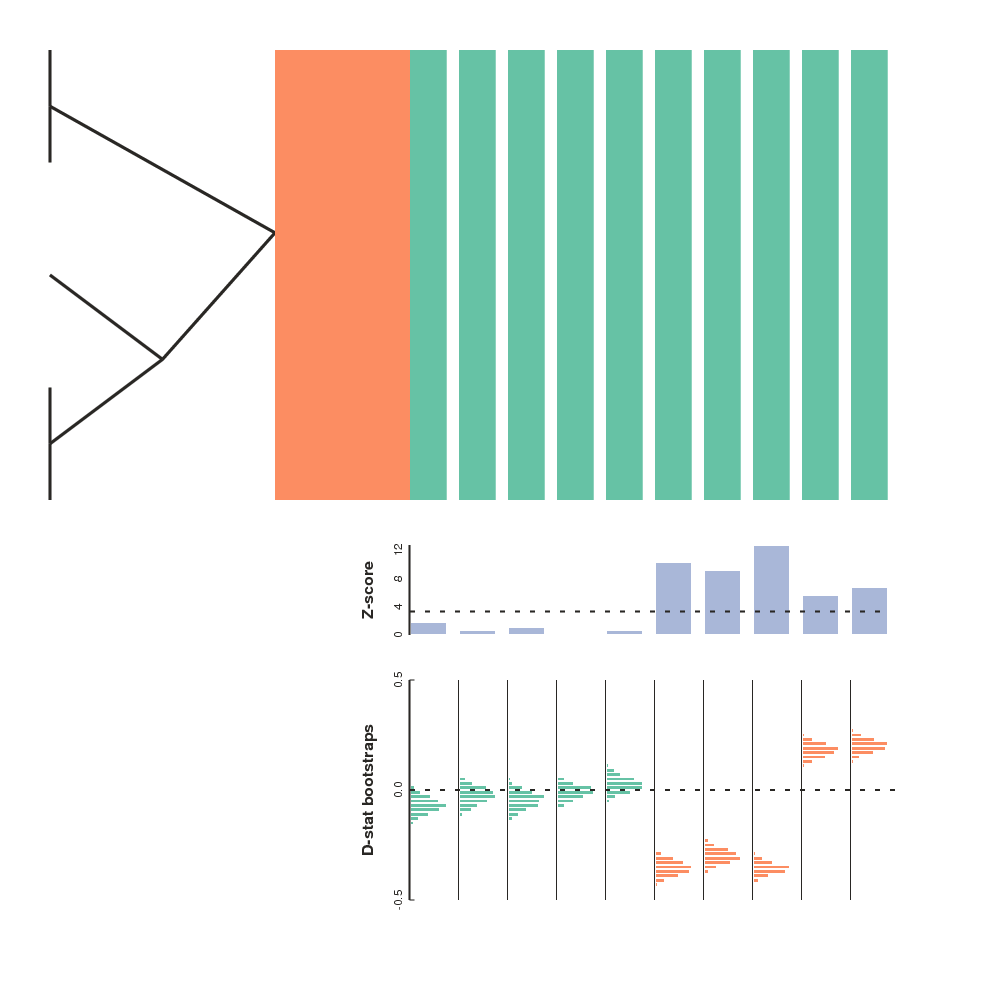

In [122]:

def panelplot(tests, resarr, bootsarr, tree):

    ## setup canvas height in three parts 
    canvas = toyplot.Canvas(width=1000, height=1000)

    ## plot min/max
    pwmin = canvas.width * 0.05
    pwmax = canvas.width * 0.95
    phmin = canvas.height * 0.05
    phmax = canvas.height * 0.95
    pwidth = pwmax - pwmin
    pheight = phmax - phmin

    ## tree plot min/max ----------------------------------------------
    div_tree_xmin = pwmin
    div_tree_xmax = pwmin + pwidth * 0.25
    div_tree_ymin = phmin
    div_tree_ymax = phmin + pheight * 0.50
    dims = (div_tree_xmin, div_tree_xmax, 
            div_tree_ymin, div_tree_ymax)
    div_tree = canvas.cartesian(bounds=dims)
    div_tree.graph(edges, 
                   vcoordinates=coord, 
                   ewidth=3, 
                   ecolor=toyplot.color.near_black, 
                   vlshow=False,
                   vsize=0,
                   along='y')
    div_tree.show=False

    ## separator between tree and blocks for names --------------------
    namespace = pwidth * 0.15
    div_sep_xmax = div_tree_xmax + namespace 
    dims = (div_tree_xmax, div_sep_xmax, 
            div_tree_ymin, div_tree_ymax)
    div_sep = canvas.cartesian(bounds=dims)
    div_sep.fill([0, 100], [100, 100], color=toyplot.color.Palette()[1])
    div_sep.show = False

    ## get blocks for tests
    tests = range(10)
    ntests = len(tests)

    ## block spacers
    blocks = np.linspace(div_sep_xmax, pwidth, ntests+1)
    spacer = 0.75 * (blocks[1] - blocks[0])
    for bidx in xrange(ntests):
        ## create block 
        dims = (blocks[bidx], blocks[bidx]+spacer, 
                div_tree_ymin, div_tree_ymax)
        div_block = canvas.cartesian(bounds=dims)
        print dims
        
        ## functions to fill block based on taxonomy of test
        div_block.fill([0, 100], [100, 100])
        div_block.show = False 
     
    ## add bar plots ---------------------------------------------------
    div_z_ymin = div_tree_ymax + pheight * 0.05
    div_z_ymax = div_tree_ymax + pheight * 0.15
    fudge = 3.
    dims = (blocks[0], blocks[-1]-spacer/fudge, div_z_ymin, div_z_ymax)
    div_z = canvas.cartesian(bounds=dims)
    #print dims
    div_z.bars(blocks[1:], blocks[1:]+spacer, resarr[:, 3], 
               opacity=0.75, color=toyplot.color.Palette()[2])

    ## bars axis styling
    div_z.padding = 0.5
    div_z.y.ticks.labels.offset = 10
    div_z.y.ticks.labels.style = {"font-size": "12px"}# args['tick-font-size']}
    div_z.x.show = False#True
    div_z.y.spine.style = {"stroke-width": 2}#"2.5px"}
    ## bars y-label
    div_z.y.label.text = "Z-score"
    div_z.y.label.offset = "40px"
    div_z.y.label.style = {"font-size": "16px", #args['label-font-size'],
                           "fill": toyplot.color.near_black}
    ## add cutoff line
    cutoff = 3.3
    div_z.hlines(y = cutoff, 
                 style={"stroke-width": 2, 
                        "stroke-dasharray": "5, 10"})

    ## plot histogram distributions --------------------------------------
    rmax = np.max(np.abs(bootsarr))
    rmax = round(min(1.0, max(0.2, rmax+0.1*rmax)), 1)
    rmin = round(max(-1.0, min(-0.2, -1 * rmax)), 1)

    ## space between plots 
    div_hist_ymin = div_z_ymax + pheight * 0.05
    div_hist_ymax = pheight

    ## add the rest
    for idx in xrange(ntests):
        ## new data
        res = resarr[idx]
        boot = bootsarr[idx]
        hist = np.histogram(boot, bins=50, range=(rmin, rmax), density=True)

        ## get p-value from z-score 
        sign = res[3] > cutoff

        ## make histogram cartesians
        dims = (blocks[idx], blocks[idx]+spacer, div_hist_ymin, div_hist_ymax)
        div_hist = canvas.cartesian(bounds=dims)
        div_hist.bars(hist, along='y', color=toyplot.color.Palette()[sign])

        ## style leftmost edge
        if idx == 0:
            ## add histograms y-label
            div_hist.y.label.text = "D-stat bootstraps"
            div_hist.y.label.offset = "40px" 
            div_hist.y.label.style = {"font-size": "16px", #args['label-font-size'],
                                      "fill": toyplot.color.near_black}

            ## axes style
            div_hist.y.ticks.show = True
            div_hist.y.ticks.labels.style = {"font-size": "12px", 
                                             "fill": toyplot.color.near_black}
            #args['tick-font-size']}
            div_hist.y.ticks.labels.offset = 10
            div_hist.y.spine.style = {"stroke-width": 2}#"2.5px"}
        else:        
            ## styling left most
            div_hist.y.ticks.show = False
            div_hist.y.ticks.labels.show = False
            
        ## shared axis style
        div_hist.x.show = False
        div_hist.padding = 0.5

    ## add dash through histograms
    dims = (blocks[0], blocks[-1], div_hist_ymin, div_hist_ymax)
    div_hist = canvas.cartesian(bounds=dims)
    div_hist.hlines(y = 0, style={"stroke-width": 2, 
                                  "stroke-dasharray": "5, 10"})
    div_hist.show = False

    return canvas


panelplot(tests, resarr, bootsarr)

In [30]:
canvas, axes, mark = toyplot.graph(edges,
                        along='y', 
                        vcoordinates=coord,
                        width=300, 
                        height=300,
                        ecolor=toyplot.color.near_black,
                        ewidth=3, 
                        vsize=20, 
                        vopacity=0.85)
                        

axes.show = True
axes.aspect = None
axes.y.show = True

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 0 3 6 9 0 10 20 30 40

### Function to convert ms to arr
This is useful for testing results

In [31]:
import msprime as ms

tree_sequence = ms.simulate(sample_size=5, Ne=1000)
tree = next(tree_sequence.trees())
print(tree)

{0: 5, 1: 5, 2: 7, 3: 6, 4: 7, 5: 6, 6: 8, 7: 8, 8: -1}


In [32]:
def migration_example():
    
    # M is overall symmetric migration rate, d is number of demes
    M = 0.2
    d = 3

    # Rescale m into per-generation values for msprime.
    m = M / (4 * (d - 1))
    
    # Allocate the initial sample. Because we are interested in the
    # between deme coalescence times, we choose one sample each
    # from the first two demes.
    population_configurations = [
        ms.PopulationConfiguration(sample_size=1),
        ms.PopulationConfiguration(sample_size=1),
        ms.PopulationConfiguration(sample_size=0)]
    
    # Now we set up the migration matrix. Since this is a symmetric
    # island model, we have the same rate of migration between all
    # pairs of demes. Diagonal elements must be zero.
    migration_matrix = [
        [0, m, m],
        [m, 0, m],
        [m, m, 0]]
    
    # We pass these values to the simulate function, and ask it
    # to run the required number of replicates.
    num_replicates = int(1e6)
    replicates = ms.simulate(
        population_configurations=population_configurations,
        migration_matrix=migration_matrix,
        num_replicates=num_replicates)
    
    # And then iterate over these replicates
    T = np.zeros(num_replicates)
    for i, trees in enumerate(replicates):
        tree = next(trees.trees())
        
        # Convert the TMRCA to coalecent units.
        T[i] = tree.get_time(tree.get_root()) / 4
        
    # Calculate analytical expectation
    analytical = d / 2. + (d - 1) / (2. * M)
    print("Observed  =", np.mean(T))
    print("Predicted =", analytical)


In [33]:
migration_example()

('Observed  =', 6.4968028913321261)
('Predicted =', 6.5)


## Simulation scenario of 12 taxon tree

Simulated data on a 12 taxon tree. Big split: (A,B,C,D) ((E,F,G,H),(I,J,K,L)). Gene flow occurs from IJ -> H, and from C->B. 



In [34]:
def demography(nreps, Ns=500000, gen=20):
    
    # Set the ML values of various parameters
    Taus = np.array([0, 1, 2, 3, 4, 5]) * 1e4 * gen
      
    # Migration rates C -> B and from IJ -> EF
    m_C_B = 2e-6
    m_IJ_EF = 2e-6
    
    # Population IDs correspond to their indexes in pop_config.
    pop_config = [
        ms.PopulationConfiguration(sample_size=2, initial_size=Ns)
        for i in range(12)]
    
    ## migration matrix all zeros time=0
    migmat = np.zeros((12, 12)).tolist()
    
    ## set up demography
    demog = [
        ## initial migration from C -> B
        ms.MigrationRateChange(time=0, rate=m_C_B, matrix_index=(1, 2)),
        ms.MigrationRateChange(time=Taus[1], rate=0),

        # merge events at time 1 (b,a), (f,e), (j,i)
        ms.MassMigration(time=Taus[1], source=1, destination=0, proportion=1.0), 
        ms.MassMigration(time=Taus[1], source=5, destination=4, proportion=1.0), 
        ms.MassMigration(time=Taus[1], source=9, destination=8, proportion=1.0), 
        
        ## migration from IJ -> EF (backward in time)
        ms.MigrationRateChange(time=Taus[1], rate=m_IJ_EF, matrix_index=(4, 8)), 

        ## merge events at time 2 (c,a), (g,e), (k,i)
        ms.MassMigration(time=Taus[2], source=2, destination=0, proportion=1.0), 
        ms.MassMigration(time=Taus[2], source=6, destination=4, proportion=1.0), 
        ms.MassMigration(time=Taus[2], source=10, destination=8, proportion=1.0), 

        ## end migration at ABC and merge
        ms.MigrationRateChange(time=Taus[2], rate=0),
        ms.MassMigration(time=Taus[3], source=3, destination=0, proportion=1.0), 
        ms.MassMigration(time=Taus[3], source=7, destination=4, proportion=1.0), 
        ms.MassMigration(time=Taus[3], source=11, destination=8, proportion=1.0),   
        
        ## merge EFJH -> IJKL
        ms.MassMigration(time=Taus[4], source=8, destination=4, proportion=1.0),   
        
        ## merge ABCD -> EFJHIJKL
        ms.MassMigration(time=Taus[5], source=4, destination=0, proportion=1.0),   
    ]

    ## sim the data
    replicates = ms.simulate(
        population_configurations=pop_config,
        migration_matrix=migmat,
        demographic_events=demog,
        num_replicates=nreps,
        length=100, 
        mutation_rate=1e-9)
    
    return replicates

In [35]:
demography(100)

<generator object _replicate_generator at 0x7f6df57cb0f0>

### Convert simulation reps into a ndarray

In [36]:
## function to convert trees to arr
def msp_to_arr(simreps, test):
    
    ## the fixed tree dictionary
    fix = {j: [i, i+1] for j, i in zip(list("abcdefghijkl"), range(0, 24, 2))}
    
    ## fill taxdict by test
    keys = ['p1', 'p2', 'p3', 'p4']
    taxs = [test[key] for key in keys]
    idxs = [list(itertools.chain(*[fix[j] for j in i])) for i in taxs]

    ## array to fill, limit to 100 len
    arr = np.zeros((100000, len(idxs), 100))
    
    ## iterate over reps filling arr
    for idx, trees in enumerate(simreps):
        
        ## build genotype array
        shape = trees.get_num_mutations(), trees.get_sample_size()
        garr = np.empty(shape, dtype="u1")
    
        ## fill the garr
        for variant in trees.variants():
            garr[variant.index] = variant.genotypes
        
        if garr.shape[0]:
            ## fill my arr with freqs
            for pdx, tax in enumerate(idxs):
                freq = garr[:, tax]
                freq = freq.sum(axis=1) / float(freq.shape[1])
                maxsz = min(freq.shape[0], 100)
                arr[idx, pdx, :maxsz] = freq[:maxsz]
    
    ## reduce the size of arr to min loci        
    arr = arr[:idx+1]
    
    ## reduce the size of arr to min len
    minl = np.where(np.all(np.all(arr==0, axis=1) == True, axis=0))[0].min()
    arr = arr[:, :, :minl]
    
    return arr

In [37]:
## pick the taxa
test = {
    'p4': ['j', 'k', 'l'],
    'p3': ['e', 'f'],
    'p2': ['c', 'd'],
    'p1': ['a', 'b'],
}
## mindict
mindict = {key: 1 for key in test}

In [50]:
nreps = 1000
nboots = 1000
sims = demography(nreps)
arr = msp_to_arr(sims, test)
res, boots = baba.baba(arr, test, mindict, nboots)
res

array([ 0.1144732 ,  0.1161982 ,  0.09367568,  1.22201629])

In [64]:
def sim_and_baba(nreps, test, mindict, nboots):
    sims = demography(nreps)
    arr = msp_to_arr(sims, test)
    stats, boots = baba.baba(arr, test, mindict, nboots)
    return stats, boots

def sim_and_abbba(nreps, test, mindict, nboots):
    sims = demography(nreps)
    arr = msp_to_arr(sims, test)
    ## ...calc
    ##return stats, boots
    return arr

In [65]:
## run one analysis of 1000 bootstraps
#sims = demography(nreps)
#arr = msp_to_arr(sims, test)
#res, boots = baba.baba(arr, test)
    
resarr, bootsarr = sim_and_baba(1000, test, mindict, 1000)   
hist = np.histogram(bootsarr, bins=50, range=(-1, 1), density=True)

## plot 1000 boots for a boots and mean
canvas, axes, mark = toyplot.bars(hist, width=300, height=250);

-1.0 -0.5 0.0 0.5 1.0 0 1 2 3 4 
 
 
 Save as .csv

In [53]:
## check; dist should be normal; Looks normal.
#dist = [simit(10000, test, mindict, 1000)[0][3] for i in range(1000)]
#hh = np.histogram(dist, 50)
#toyplot.bars(hh, width=400, height=300);

### 4-taxon tests

In [74]:
tests = [
    ## no introgression
    {
    'p4': ['a', 'b', 'c', 'd'],
    'p3': ['l'],
    'p2': ['j'],
    'p1': ['k'],
}, 
    ## no introgression
    {
    'p4': ['e','f','g','h'],
    'p3': ['d'],
    'p2': ['b'],
    'p1': ['a'],
}, 
    ## no introgression
    {
    'p4': ['h'],
    'p3': ['g'],
    'p2': ['f'],
    'p1': ['e'],
}, 
    ## no introgression
    {
    'p4': ['a', 'b', 'c', 'd'],
    'p3': ['g'],
    'p2': ['f'],
    'p1': ['e'],
}, 
    ## no introgression
    {
    'p4': ['a', 'b', 'c', 'd'],
    'p3': ['k'],
    'p2': ['j'],
    'p1': ['i'],
}, 
    ## introgression 
    {
    'p4': ['a', 'b', 'c', 'd'],
    'p3': ['i', 'j'],
    'p2': ['g'],
    'p1': ['f'],
},
    ## introgression 
    {
    'p4': ['a', 'b', 'c', 'd'],
    'p3': ['i', 'j'],
    'p2': ['g'],
    'p1': ['e'],
},
    ## introgression 
    {
    'p4': ['a', 'b', 'c', 'd'],
    'p3': ['i', 'j'],
    'p2': ['g'],
    'p1': ['e', 'f'],
},   
    ## introgression C->B
    {
    'p4': ['e','f','g','h'],
    'p3': ['c'],
    'p2': ['b'],
    'p1': ['a'],
},     
    ## introgression C->B
    {
    'p4': ['i', 'j', 'k', 'l'],
    'p3': ['c'],
    'p2': ['b'],
    'p1': ['a'],
},         

]

tests    

[{'p1': ['k'], 'p2': ['j'], 'p3': ['l'], 'p4': ['a', 'b', 'c', 'd']},
 {'p1': ['a'], 'p2': ['b'], 'p3': ['d'], 'p4': ['e', 'f', 'g', 'h']},
 {'p1': ['e'], 'p2': ['f'], 'p3': ['g'], 'p4': ['h']},
 {'p1': ['e'], 'p2': ['f'], 'p3': ['g'], 'p4': ['a', 'b', 'c', 'd']},
 {'p1': ['i'], 'p2': ['j'], 'p3': ['k'], 'p4': ['a', 'b', 'c', 'd']},
 {'p1': ['f'], 'p2': ['g'], 'p3': ['i', 'j'], 'p4': ['a', 'b', 'c', 'd']},
 {'p1': ['e'], 'p2': ['g'], 'p3': ['i', 'j'], 'p4': ['a', 'b', 'c', 'd']},
 {'p1': ['e', 'f'], 'p2': ['g'], 'p3': ['i', 'j'], 'p4': ['a', 'b', 'c', 'd']},
 {'p1': ['a'], 'p2': ['b'], 'p3': ['c'], 'p4': ['e', 'f', 'g', 'h']},
 {'p1': ['a'], 'p2': ['b'], 'p3': ['c'], 'p4': ['i', 'j', 'k', 'l']}]

### Run a batch of tests

In [58]:
## run batch tests
resarr, bootsarr = baba.batch(handle, tests, mindicts=None, nboots=1000, ipyclient=ipyclient)

## plot bootstraps
#baba.bootplot(resarr, bootsarr, width=400)
resarr
#bootsarr

  [####################] 100%  calculating D-stats  | 0:00:00 |  


array([[  0.,   0.,   0.,  nan],
       [  0.,   0.,   0.,  nan],
       [  0.,   0.,   0.,  nan],
       [  0.,   0.,   0.,  nan],
       [  0.,   0.,   0.,  nan],
       [  0.,   0.,   0.,  nan],
       [  0.,   0.,   0.,  nan],
       [  0.,   0.,   0.,  nan],
       [  0.,   0.,   0.,  nan],
       [  0.,   0.,   0.,  nan]])

In [75]:
print handle
print test
print mindict

#baba.baba(handle, test, mindict, nboots=1000)
bootsarr.shape

/home/deren/Documents/ipyrad/tests/cli/cli_outfiles/cli.loci
[{'p2': ['j'], 'p3': ['l'], 'p1': ['k'], 'p4': ['a', 'b', 'c', 'd']}, {'p2': ['b'], 'p3': ['d'], 'p1': ['a'], 'p4': ['e', 'f', 'g', 'h']}, {'p2': ['f'], 'p3': ['g'], 'p1': ['e'], 'p4': ['h']}, {'p2': ['f'], 'p3': ['g'], 'p1': ['e'], 'p4': ['a', 'b', 'c', 'd']}, {'p2': ['j'], 'p3': ['k'], 'p1': ['i'], 'p4': ['a', 'b', 'c', 'd']}, {'p2': ['g'], 'p3': ['i', 'j'], 'p1': ['f'], 'p4': ['a', 'b', 'c', 'd']}, {'p2': ['g'], 'p3': ['i', 'j'], 'p1': ['e'], 'p4': ['a', 'b', 'c', 'd']}, {'p2': ['g'], 'p3': ['i', 'j'], 'p1': ['e', 'f'], 'p4': ['a', 'b', 'c', 'd']}, {'p2': ['b'], 'p3': ['c'], 'p1': ['a'], 'p4': ['e', 'f', 'g', 'h']}, {'p2': ['b'], 'p3': ['c'], 'p1': ['a'], 'p4': ['i', 'j', 'k', 'l']}]
{'p2': 1, 'p3': 1, 'p1': 1, 'p4': 1}


(10, 2000)

In [76]:
nsims = 10000
nboots = 2000
ntests = len(tests)

## generate new results from sims
resarr = np.zeros((ntests, 4), dtype=np.float64)
bootsarr = np.zeros((ntests, nboots), dtype=np.float64)
for idx in xrange(ntests):
    resarr[idx], bootsarr[idx] = sim_and_baba(nsims, tests[idx], mindict, nboots)

In [215]:
def batch(handle, taxdicts, mindicts=None, nboots=100, ipyclient=None, quiet=False):
    """
    parallel mode
    """

    ## an array to hold results (len(taxdicts), nboots)
    tot = len(taxdicts)
    resarr = np.zeros((tot, 4), dtype=np.float64)
    bootarr = np.zeros((tot, nboots), dtype=np.float64)

    ## if no ipyclient then assume Default is running, else raise error
    if not ipyclient:
        pass

    ## submit jobs to run on the cluster queue
    else:
        ## get client
        start = time.time()
        lbview = ipyclient.load_balanced_view()
        asyncs = {}
        idx = 0
    
        ## iterate over tests (repeats mindicts if fewer than taxdicts)
        for test, mindict in zip(taxdicts, itertools.cycle([mindicts])):
            asyncs[idx] = lbview.apply(baba.baba, *(handle, test, mindict, nboots))
            idx += 1

        ## block until finished, print progress if requested.
        while 1:
            keys = [i for (i, j) in asyncs.items() if j.ready()]
            ## check for failures
            for job in keys:
                if not asyncs[job].successful():
                    raise IPyradWarningExit(\
                        " error: {}: {}".format(job, asyncs[job].exception()))
                ## enter results for successful jobs
                else:
                    resarr[job], bootarr[job] = asyncs[job]
                    del asyncs[job]

            ## count finished
            fin = tot - len(asyncs) 
            elap = datetime.timedelta(seconds=int(time.time()-start))
            progressbar(tot, fin, " calculating D-stats  | {} | ".format(elap))
            time.sleep(0.5)
            if not asyncs:
                print("")
                break

        return resarr, bootarr

In [216]:
from ipyrad.assemble.write_outfiles import reftrick, GETCONS
from ipyrad.assemble.util import *

import ipyparallel as ipp
import ipyrad as ip
import pandas as pd
import numpy as np
import numba
import itertools
import datetime
import time

batch(handle, tests, mindict, nboots=500, ipyclient=ipyclient)

  [                    ]   0%  calculating D-stats  | 0:00:00 |  

IPyradError:  error: 0: NameError(global name '_get_signif' is not defined)

## Empirical test

In [174]:
## generate new sim data


array([[  2.30811361e-02,   2.12330020e-02,   3.70508544e-02,
          6.22958268e-01],
       [ -1.00798403e-02,  -1.00655995e-02,   4.06701025e-02,
          2.47843986e-01],
       [ -3.00240192e-02,  -3.00848187e-02,   4.06340073e-02,
          7.38888956e-01],
       [ -9.75810885e-03,  -1.06482189e-02,   3.30249602e-02,
          2.95476779e-01],
       [ -3.98500530e-02,  -3.85985436e-02,   3.70518275e-02,
          1.07552193e+00],
       [ -3.82062942e-01,  -3.82672442e-01,   3.40253643e-02,
          1.12287686e+01],
       [ -3.26805135e-01,  -3.25466986e-01,   3.30336909e-02,
          9.89308571e+00],
       [ -3.15603257e-01,  -3.15846793e-01,   2.94832431e-02,
          1.07044960e+01],
       [  1.95442769e-01,   1.95551411e-01,   3.07207251e-02,
          6.36191915e+00],
       [  1.49224931e-01,   1.51264416e-01,   3.16579989e-02,
          4.71365645e+00]])

### Calculate 4-taxon statistics
<br>

$
    D = \frac{\Sigma(ABBA - BABA)}{\Sigma(ABBA+BABA)}
$

<br>

$
    D_p = \frac{\Sigma ~ [ p_1 ~ (1-p_2) ~ p_3 ~ (1-p_4) ] - [(1-p_1) ~ p_2 ~ p_3 ~ (1-p_4)]}      {\Sigma ~ [ p_1 ~ (1-p_2) ~ p_3 ~ (1-p_4) ] + [(1-p_1) ~ p_2 ~ p_3 ~ (1-p_4)]}
$

<br>

In [1215]:
@numba.jit(nopython=True)
def prop_dstat(arr):
    
    ## numerator
    abba = ((1.-arr[:, 0]) * (arr[:, 1]) * (arr[:, 2]) * (1.-arr[:, 3]))  
    baba = ((arr[:, 0]) * (1.-arr[:, 1]) * (arr[:, 2]) * (1.-arr[:, 3]))
    top = abba - baba
    bot = abba + baba

    ## get statistic and avoid zero div   
    if bot.sum() != 0:
        dstat = top.sum() / float(bot.sum())
    else:
        dstat = 0
    
    return abba.sum(), baba.sum(), dstat

In [1216]:
prop_dstat(arr)

nboots = 100
boots = np.zeros((nboots, 1))

## iterate to fill boots
for bidx in xrange(nboots):
    ## sample with replacement
    lidx = np.random.randint(0, arr.shape[0], arr.shape[0])
    tarr = arr[lidx]
    abba, baba, dstat = prop_dstat(tarr)
    boots[bidx] = dstat

In [1217]:
@numba.jit(nopython=True)
def get_boots(arr, nboots=1000):
    ## hold results (nboots, [dstat, ])
    boots = np.zeros((nboots, 1))
    
    ## iterate to fill boots
    for bidx in xrange(nboots):
        ## sample with replacement
        lidx = np.random.randint(0, arr.shape[0], arr.shape[0])
        tarr = arr[lidx]
        _, _, dstat = prop_dstat(tarr)
        boots[bidx] = dstat
    
    ## return bootarr
    return boots

In [1218]:
@numba.jit(nopython=True)
def get_signif(arr, nboots):
    abba, baba, dstat = prop_dstat(arr)
    b = get_boots(arr)
    e, s = (b.mean(), b.std())
    z = np.abs(dstat) / s
    return dstat, e, s, z
    

In [1219]:
get_signif(arr, 1000)

ZeroDivisionError: division by zero

### Setup a 5-taxon test

In [192]:
## a dictionary with [required] key names 
## optional: additional 'p4' key for 5-taxon tests.
test = {
    'p5': ["3L_0", "3J_0", "3K_0"], 
    'p4': ["2G_0", "2H_0"],
    'p3': ["2E_0", "2F_0"],
    'p2': ["1D_0"],
    'p1': ["1A_0", "1B_0", "1C_0"],
}

## optional: dict for min samples per taxon (default=1 per tax)
## used to filter loci for inclusion in data set
mindict = {
    'p1': 1,
    'p2': 1,
    'p3': 1, 
    'p4': 1,
    'p5': 1,
}

## loci input file
handle = data.outfiles.loci

In [ ]:
baba.baba()

In [191]:
## get locus array
arr = baba.loci_to_arr(handle, test)

## simulate data
nreps = 10000
simreps = demography(nreps)

## A, B, C, D
inds = np.array([[0,1],[2,3],[4,5],[6,7]])

## [E], [H], [I], [L], [A,B,C,D]
inds = np.array([[8,9], [14,15], [16,17], [22,23], [0,1,2,3,4,5,6,7]])

## convert to freq arr
arr = msp_to_arr(nreps, simreps, inds)
arr.shape

AttributeError: 'module' object has no attribute 'loci_to_arr'

## Calculate 5-taxon statistics

<br>

$
    D_{12} = \frac{\Sigma(ABBBA - BABBA)}{\Sigma(ABBBA+BABBA)}
$

$
    D_{1} = \frac{\Sigma(ABBAA - BABAA)}{\Sigma(ABBAA+BABAA)}
$

$
    D_{2} = \frac{\Sigma(ABABA - BAABA)}{\Sigma(ABABA+BAABA)}
$

<br>

$
    D_{p12} = \frac 
        {\Sigma ~ [ p_1 ~ (1-p_2) ~ p_3 ~ p_4 ~ (1-p_5) ] - [(1-p_1) ~ p_2 ~ p_3 ~ p_4 ~ (1-p_5)]} 
        {\Sigma ~ [ p_1 ~ (1-p_2) ~ p_3 ~ p_4 ~ (1-p_4) ] + [(1-p_1) ~ p_2 ~ p_3 ~ p_4 ~ (1-p_5)]}
$


$
    D_{p1} = \frac 
        {\Sigma ~ [ p_1 ~ (1-p_2) ~ p_3 ~ (1-p_4) ~ (1-p_5) ] - [(1-p_1) ~ p_2 ~ p_3 ~ (1-p_4) ~ (1-p_5)]} 
        {\Sigma ~ [ p_1 ~ (1-p_2) ~ p_3 ~ (1-p_4) ~ (1-p_5) ] + [(1-p_1) ~ p_2 ~ p_3 ~ (1-p_4) ~ (1-p_5)]}
$


$
    D_{p2} = \frac 
        {\Sigma ~ [ p_1 ~ (1-p_2) ~ (1-p_3) ~ p_4 ~ (1-p_5) ] - [(1-p_1) ~ p_2 ~ (1-p_3) ~ p_4 ~ (1-p_5)]} 
        {\Sigma ~ [ p_1 ~ (1-p_2) ~ (1-p_3) ~ p_4 ~ (1-p_5) ] + [(1-p_1) ~ p_2 ~ (1-p_3) ~ p_4 ~ (1-p_5)]}
$

<br>

In [1181]:
@numba.jit(nopython=True)
def prop_dstat_12(arr):
    
    ## calc
    sub = ((arr[:, 2] + arr[:, 3]) / 2.)
    abbba = ((1.-arr[:, 0]) * (arr[:, 1]) * sub * (1.-arr[:, 4]))
    babba = ((arr[:, 0]) * (1.-arr[:, 1]) * sub * (1.-arr[:, 4]))
    top = abbba - babba
    bot = abbba + babba

    ## get statistic and avoid zero div   
    if bot.sum() != 0:
        dstat = top.sum() / float(bot.sum())
    else:
        dstat = 0
    
    return abbba.sum(), babba.sum(), dstat

In [1182]:
@numba.jit(nopython=True)
def prop_dstat_1(arr):
    
    ## numerator
    sub = (arr[:, 2]) * (1.-arr[:, 3])
    abbaa = ((1.-arr[:, 0]) * (arr[:, 1]) * sub * (1.-arr[:, 4]))
    babaa = ((arr[:, 0]) * (1.-arr[:, 1]) * sub * (1.-arr[:, 4]))
    top = abbaa - babaa
    bot = abbaa + babaa

    ## get statistic and avoid zero div   
    if bot.sum() != 0:
        dstat = top.sum() / float(bot.sum())
    else:
        dstat = 0
    
    return abbaa.sum(), babaa.sum(), dstat

In [1183]:
@numba.jit(nopython=True)
def prop_dstat_2(arr):
    
    ## calc sub
    sub = (1.-arr[:, 2]) * arr[:, 3] 
    
    ## calc stats
    ababa = ((1.-arr[:, 0]) * (arr[:, 1]) * sub * (1.-arr[:, 4]))
    baaba = ((arr[:, 0]) * (1.-arr[:, 1]) * sub * (1.-arr[:, 4]))
    top = ababa - baaba
    bot = ababa + baaba

    ## get statistic and avoid zero div   
    if bot.sum() != 0:
        dstat = top.sum() / float(bot.sum())
    else:
        dstat = 0
    
    return ababa.sum(), baaba.sum(), dstat

In [1184]:
sub = (1.-arr[:, 2]) * arr[:, 3]

print arr[:5, 3, :10]
print arr[:5, 2, :10]
print sub[:5, :10]

[[ 0.   0.   0.   1.   0.   0.   0.   0.   0.   0. ]
 [ 1.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 1.   0.   0.5  0.   0.   0.   1.   0.   0.   0. ]]
[[ 0.   0.   0.   0.   0.   0.   1.   0.   1.   0. ]
 [ 0.   1.   0.5  0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   1.   0.   1.   0. ]
 [ 1.   0.   1.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.5  1.   0.   0.   0.   0.   0. ]]
[[ 0.   0.   0.   1.   0.   0.   0.   0.   0.   0. ]
 [ 1.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 1.   0.   0.5  0.   0.   0.   1.   0.   0.   0. ]]


In [1185]:
prop_dstat_12(arr), 'abbba babba'

((2036.0, 24.25, 0.9764591675767504), 'abbba babba')

In [1186]:
print prop_dstat_1(arr), 'abbaa, babaa'
print prop_dstat_2(arr), 'ababa, baaba'

(3998.5, 6.0, 0.9970033712073917) abbaa, babaa
(0.5, 42.5, -0.9767441860465116) ababa, baaba


In [1026]:
sub = (1.-arr[:, 2]) * arr[:, 3] 
sub[:20, :10]

array([[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.5,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  0.5,  0. ],
       [ 0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 1. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.5,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  0. ],
       [ 0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 1. ,  0.5,  0. ,  0. ,  0

In [1021]:
prop_dstat_2(arr)

(195.125, 17.0, 0.8397171479080731)

In [1006]:
x = arr[:, 3]
y = arr[:, 2]

print x[:10, :8]
print y[:10, :8]
z = x-y
print z[:10, :8]

[[ 0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.125  0.125  0.125  0.     0.     0.     0.     0.   ]
 [ 0.625  0.25   0.375  0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.125  0.     0.25   0.125  0.125]
 [ 0.125  0.     0.     0.125  0.25   0.375  0.     0.125]
 [ 0.5    0.     0.     0.     0.25   0.     0.     0.   ]
 [ 1.     0.     0.75   0.     0.     0.     0.75   0.   ]
 [ 0.125  0.25   0.     0.25   0.125  0.     0.     0.   ]
 [ 0.     0.     0.25   0.     0.125  0.625  0.     0.   ]
 [ 0.     0.     0.     0.     0.75   0.25   0.     1.   ]]
[[ 0.25  0.    0.    1.    0.    0.5   0.    0.5 ]
 [ 0.    0.    0.    0.    0.5   0.    0.    0.  ]
 [ 0.    0.    0.    1.    0.75  0.    0.    1.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.5   0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    1.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    1.    0.    0.    0.5 ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]
 

In [1000]:
sub = (arr[:, 3] + (arr[:, 2]))
sub - arr[:, 2]#* (1.-arr[:, 2])

x = arr[:, 3] * (1.-arr[:, 2])
x[:10, :8]

array([[ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.125,  0.125,  0.125,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.625,  0.25 ,  0.375,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.125,  0.   ,  0.25 ,  0.125,  0.125],
       [ 0.125,  0.   ,  0.   ,  0.125,  0.25 ,  0.375,  0.   ,  0.125],
       [ 0.5  ,  0.   ,  0.   ,  0.   ,  0.25 ,  0.   ,  0.   ,  0.   ],
       [ 1.   ,  0.   ,  0.75 ,  0.   ,  0.   ,  0.   ,  0.75 ,  0.   ],
       [ 0.125,  0.25 ,  0.   ,  0.25 ,  0.125,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.25 ,  0.   ,  0.125,  0.625,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.75 ,  0.25 ,  0.   ,  1.   ]])

In [907]:
prop_dstat_2(arr)

(79.21875, 4.9375, 0.8826587448941701)